In [1]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d.axes3d import Axes3D

%matplotlib inline

In [2]:
class TimeValue:
    def __init__(self, time, value):
        self.time = time * 1.0
        self.value = value * 1.0

    def __repr__(self):
        return '({}, {})'.format(self.time, self.value)

In [3]:
class TimeSeries:
    def __init__(self, points=[]):
        self.series = []
        for (time, value) in points:
            self.append(time, value)
        
    def append(self, time, value):
        self.series.append(TimeValue(time, value))
        self.series = sorted(self.series, key=lambda x: x.time)
        
    @property
    def initial(self):
        return self.series[0]
    
    @property
    def timeline(self):
        return [x.time for x in self.series]
    
    @property
    def values(self):
        return [x.value for x in self.series]
    
    @property
    def components(self, i=None):
        try:
            return list(zip(*self.values))
        except:
            return [self.values]

    def plot(self, toggle='0', loc=None, pad=False, grid=True, marker=None, labels=None, colors=None, lw=1):
        if len(self.components) > 1:
            plt.plot(self.timeline, self.values, marker=marker)
            if legend_loc:
                plt.legend(['x','y','z'][:len(self.components)], loc=loc, numpoints=1)
        else:
            ts = dict()
            ts['0'] = self
            ts['1'] = self.rate_of_change()
            ts['2'] = self.rate_of_change().rate_of_change()
            
            if colors is None:
                colors = [None, None, None]
            else:
                colors = colors * len(toggle) # just in case...

            if labels is None:
                labels = ['position', 'velocity', 'acceleration']
            else:
                labels += [None] * (len(toggle) - len(labels)) # just in case...

            if len(toggle) > 1:
                plt.figure(figsize=(6 * len(toggle), 4))
                
            for i, tog in enumerate(toggle):
                if len(toggle) > 1:
                    plt.subplot(1, len(toggle), toggle.index(tog) + 1)
                plt.plot(ts[tog].timeline, ts[tog].values, marker=marker, 
                         label=labels[i], color=colors[i], lw=lw)
                plt.xlabel('Time')
                if pad:
                    plt.margins(0.05)
                    dt = 0.03 * (self.timeline[-1] - self.timeline[0])
                    plt.axes().set_xlim([self.timeline[0] - dt, self.timeline[-1] + dt])
                if grid:
                    plt.grid(True)
                    plt.gca().axhline(0, c='k')
                if loc and labels[i]:
                    plt.legend(loc=loc, numpoints=1)
                            
    def plot2d(self, x_index=0, y_index=1, toggle='0', title='', colors='', label=[],
               grid=True, loc=None, markevery=0, arrows=False):
        
        r = self
        x['0'] = r.components[x_index]
        y['0'] = r.components[y_index]

        v = r.rate_of_change()
        x['1'] = v.components[x_index]
        y['1'] = v.components[y_index]

        a = v.rate_of_change()
        x['2'] = a.components[x_index]
        y['2'] = a.components[y_index]

        color = dict()
        if colors:
            color['0'] = colors
            color['1'] = colors
            color['2'] = colors
        else:
            color['0'] = 'b'
            color['1'] = 'g'
            color['2'] = 'r'            

        label = dict()
        if labels:
            label['0'] = labels[0]
            label['1'] = labels[1]
            label['2'] = labels[2]
        else:
            label['0'] = 'position'
            label['1'] = 'velocity'
            label['2'] = 'acceleration'
                
        for i, tog in toggle:
            plt.plot(x[tog], y[tog], c=color[tog], markevery=[-1], 
                     marker='o', mfc='w', mec=color[tog], mew=1)
            if markevery:
                plt.plot(x[tog], y[tog], lw=0, markevery=markevery, 
                         marker='.', mec=color[tog])
            
        plt.axes().set_aspect('equal')
        plt.margins(0.05)
        if loc:
            plt.legend(numpoints=1, loc=loc, labels=labels)
        plt.title(title)
        
        if grid:
            plt.grid(True)
            plt.axes().axhline(0, c='k')
            plt.axes().axvline(0, c='k')

        if arrows:
            xmin, xmax = plt.xlim()
            ymin, ymax = plt.ylim()
            size = 0.5 * (xmax - xmin) + 0.5 * (ymax - ymin)
            head_size = {
                'head_width': 0.03 * size,
                'head_length': 0.05 * size,
            }
            if '1' in toggle:
                plt.axes().arrow(x['0'][-1], y['0'][-1], x['1'][-1], y['1'][-1], 
                                 fc=color['1'], ec=color['1'], **head_size)
            if '2' in toggle:
                plt.axes().arrow(x['0'][-1], y['0'][-1], x['2'][-1], y['2'][-1], 
                                 fc=color['2'], ec=color['2'], **head_size)
             
    @property
    def intervals(self):
        intervals = []
        for i in range(1, len(self.series)):
            intervals.append((self.series[i - 1], self.series[i]))
        return intervals    
 
    def get_interval(self, time): # closed on left [a, b)
        tmin = min(self.timeline)
        tmax = max(self.timeline)
        if time < tmin:
            return None, self.series[0]
        elif time >= tmax:
            return self.series[-1], None
        else:
            for a, b in self.intervals:
                if a.time <= time and time < b.time:
                    return a, b
    
    def rate_of_change(self):
        ts = TimeSeries()
        for i, (a, b) in enumerate(self.intervals):
            dx = b.value - a.value
            dt = b.time - a.time
            if 1 == 0:
                ts.append(a.time, dx/dt)
            else:
                ts.append(a.time + dt/2, dx/dt)
        return ts
                
    def __call__(self, time):
        a, b = self.get_interval(time)
        # this method will not extrapolate, but we do need to take care of this edge case...
        if b is None and round(a.time - time, 10) == 0:
            return a.value
        else:
            dx = b.value - a.value
            dt = b.time - a.time
            return a.value + dx/dt * (time - a.time)

    def __getitem__(self, index):
        if isinstance(index, int):
            return self.series[index]
        elif isinstance(index, slice):
            return self.series[index]
        else:
            raise TypeError("index must be int or slice")
        
    def __repr__(self):
        import pprint
        return pprint.pformat(self.series)


In [4]:
class Particle():
    def __init__(self, mass=1, t0=0, r0=0, p0=0, v0=None):
        self.mass = mass
        self.position = TimeSeries([(t0, r0)])
        if self.mass and v0 is not None:
            self.momentum = TimeSeries([(t0, self.mass * v0)])
        else:
            self.momentum = TimeSeries([(t0, p0)])
        self.forces = []

    def addforce(self, force):
        self.forces.append(lambda t, obj=self: force(obj, t))        
        
    def netforce(self, time): # momentum flow or rate of change
        netforce = 0
        for f in self.forces:
            netforce += f(time)
        return netforce

    def velocity(self, time): # position flow or rate of change
        if time > max(self.momentum.timeline):
            time = max(self.momentum.timeline)
        return self.momentum(time) / self.mass

    def increment(self, dt, n=1):
        for i in range(n):
            t = max(self.position.timeline)

            if len(self.position.timeline) == 1: # then only go forward half an increment            
                next_p = self.momentum(t) + self.netforce(t) * dt/2
                self.momentum = TimeSeries() # throw out that "initial" value
            else: # reach back half an increment to calculate the new momentum value
                next_p = self.momentum(t - dt/2) + self.netforce(t) * dt

            self.momentum.append(t + dt/2, next_p)
            next_r = self.position(t) + self.velocity(t + dt/2) * dt        
            self.position.append(t + dt, next_r)

In [5]:
class PhysicalSystem():
    def __init__(self, initial=[]):
        self.objs = list()
        for (mass, r0, v0) in initial:
            self.objs.append(Particle(mass=mass, r0=r0, v0=v0))
                    
        for obj1 in self.objs:
            for obj2 in self.objs:
                if obj1 != obj2: # no self-interactions !
                    internal_force = lambda t, obj1=obj1, obj2=obj2: self.interaction(obj1, obj2, t)
                    obj1.forces.append(internal_force)
                    
    def interaction(self, obj1, obj2, time):
        return 0
                    
    def increment(self, dt, n=1):
        for i in range(n):
            for obj in self.objs:
                obj.increment(dt)
                
    def plot(self):
        for i, obj in enumerate(self.objs):
            obj.position.plot(legend_loc=None)
            
    def plot2d(self, colors='bgrcmyk'*9, **kwargs):
        for i, obj in enumerate(self.objs):
            obj.position.plot2d(color=colors[i], **kwargs)

In [6]:
import cmath

class RigidObject(Particle):
    def __init__(self, mass=1, t0=0, r0=0, p0=0, v0=None, moi=1, q0=1+0j, L0=0+0j, w0=None):
        Particle.__init__(self, mass, t0, r0, p0, v0)
        self.moi = moi
        self.attitude = TimeSeries([(t0, q0)])
        self.angular_displacement = TimeSeries([(t0, cmath.phase(q0))])
        if self.moi and w0 is not None:
            self.angular_momentum = TimeSeries([(t0, self.moi * w0)])
        else:
            self.angular_momentum = TimeSeries([(t0, L0)])
        self.torques = []
    
    def add_torque(self, torque):
        self.torques.append(lambda t, obj=self: torque(obj, t))        
        
    def net_torque(self, time): # angular_momentum flow or rate of change
        net_torque = 0+0j
        for tau in self.torques:
            net_torque += tau(time)
        return net_torque

    def rotational_velocity(self, time): # attitude flow or rate of change
        if time > max(self.angular_momentum.timeline):
            time = max(self.angular_momentum.timeline)
        return self.angular_momentum(time) / self.moi
    
    def increment(self, dt, n=1):
        for i in range(n):
            Particle.increment(self, dt, 1)
            
            t = max(self.attitude.timeline)

            if len(self.attitude.timeline) == 1: # then only go forward half an increment            
                next_L = self.angular_momentum(t) + self.net_torque(t) * dt/2
                self.angular_momentum = TimeSeries() # throw out that "initial" value
            else: # reach back half an increment to calculate the new momentum value
                next_L = self.angular_momentum(t - dt/2) + self.net_torque(t) * dt                

                q = self.angular_displacement(t - dt)
                q += self.rotational_velocity(t + dt/2) * dt
                self.angular_displacement.append(t, q)

            self.angular_momentum.append(t + dt/2, next_L)
            rotor = np.exp( 1j * self.rotational_velocity(t + dt/2) * dt )
            next_attitude = self.attitude(t) * rotor
            self.attitude.append(t + dt, next_attitude)

- Ch 01: 1,3,5,12,13,45,46,49,59,61
- Ch 02: 1,3,15,28,29,45,51,53,67,68,78,79,81
- Ch 03: 5,7,8,9,19,30,35,57,59,69,71
- Ch 04: 1,11,38,39,42,56,79,81,98,103,104
- Ch 05: 5,7,8,9,15,23,27,31,41,52,56
- Ch 06: 3,5,6,8,13,19,29,33,38,41,64,68,77
- Ch 07: 1,5,7,19,21,29,31,33,35,41
- Ch 08: 1,3,9,21,23,25,37,39,42,53,54,56,68,69
- Ch 09: 1,6,12,15,31,33,34,48,51,63,64,71,73

## Chapter 2

**Problem 003**

Due to continental drift, the North American and European continents are drifiting apart at an average speed of about 0.03 meters per year. At this speed, how long (in years) will it take for them to drift apart by another 1500 meters? 

*Answer:* 50,000 years

Drift time = 50,000 years


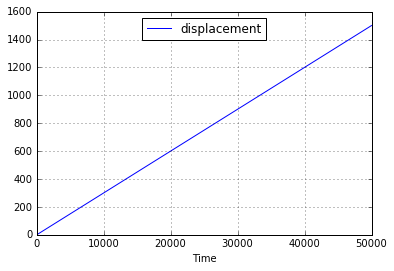

In [557]:
obj = Particle(v0=0.03)
while obj.position.values[-1] < 1500:
    obj.increment(dt=100)
print('Drift time = {:,.0f} years'.format(obj.position.timeline[-1]))
obj.position.plot(loc='upper center', labels=['displacement'])

**Problem 015** 

(a) Suppose that a NASCAR race car is moving to the right with a constant velocity of +82 m/s. What is the average acceleration of of car? (b) Twelve seconds later, the car is halfway around the track and traveling in the opposite direction with the same speed. What is the average acceleration of the car?

*Answer:* (a) 0 m/s² (b) −14 m/s²

In [8]:
v = TimeSeries()
v.append(0,82)
v.append(12,82)
a = v.rate_of_change()
print('Acceleration = {:.2f} m/s²'.format(a.values[-1]))

v = TimeSeries()
v.append(0,82)
v.append(12,-82)
a = v.rate_of_change()
print('Acceleration = {:.2f} m/s²'.format(a.values[-1]))

Acceleration = 0.00 m/s²
Acceleration = -13.67 m/s²


**Problem 028**

(a) What is the magnitude of the average acceleration of a skier who, starting from rest, reaches a speed of 8.0 m/s when going down a slope for 5.0 seconds? (b) How far does the skier travel in this time?

*Answer:* (a) 1.6 m/s²; (b) 20 meters

Acceleration = 1.62 m/s²
Final position = 20.21 meters


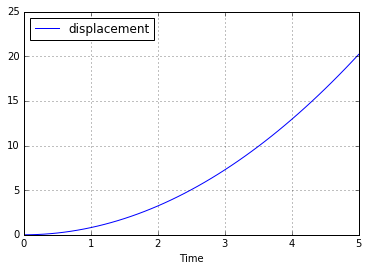

In [9]:
a = 1.6

for da in [1, 0.1, 0.01, 0.001]:
    while True:
        obj = Particle(v0=0)
        obj.netforce = lambda t: a
        obj.increment(0.1,50)
        if obj.velocity(5.0) > 8.0:
            a += -da
            break
        else:
            a += da
        
print('Acceleration = {:.2f} m/s²'.format(a))
print('Final position = {:.2f} meters'.format(obj.position.values[-1]))
obj.position.plot(loc='upper left', labels=['displacement'])

**Problem 029**

A jetliner, traveling northward, is landing with a speed of 69 m/s. Once the jet touches down, it has 750 meters of runway in which to reduce its speed to 6.1 m/s. Compute the average acceleration of the plane during landing.

*Answer:* −3.1 m/s²

Acceleration = 3.15 m/s²
Final position = 750 meters
Final velocity = 6.10 m/s


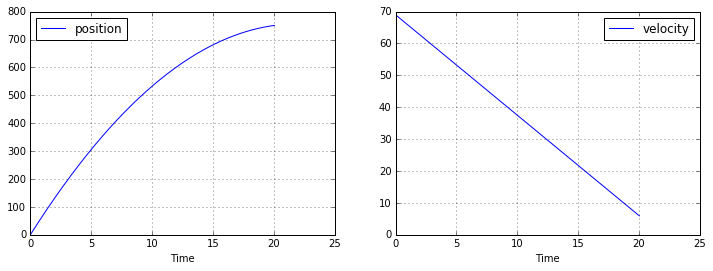

In [10]:
dt = 0.05 # this solution method is very sensitive to `dt` for some reason

a = 0
for da in [1, 0.1, 0.01, 0.001]:
    while True:
        a += da

        obj = Particle(v0=69)
        obj.netforce = lambda t: -a
        
        while True:
            t = obj.position.timeline[-1]
            x = obj.position.values[-1]
            v = obj.velocity(t)
            obj.increment(dt)
            if x >= 750 or v <= 6.1:
                break

        if v <= 6.1:
            a += -da
            break

print('Acceleration = {:.2f} m/s²'.format(a))
print('Final position = {:.0f} meters'.format(x))
print('Final velocity = {:.2f} m/s'.format(v))

obj.position.plot('01', loc='best', labels=['position','velocity'])

**Problem 045**

A piece of cardboard can be used to measure a person's reaction time. Hold the card at the top and suddenly drop it. Ask a friend to try to catch the card between his or her thumb and index finger. Initially, your friend's fingers must be level with the bottom of the card. By noting where your friend catches the card, you can determine his or her reaction time in milliseconds. Calculate the distance `d1` (180 ms), `d2` (120 ms), and `d3` (60.0 ms).

*Answer:* (a) 0.018 meters (b) 0.071 meters (c) 0.16 meters

In [11]:
ts = Particle(v0=0)
ts.netforce = lambda t: -9.8
ts.increment(0.001,60)
print('Final position = {:.3f} meters'.format(ts.position.values[-1]))
ts.increment(0.001,60)
print('Final position = {:.3f} meters'.format(ts.position.values[-1]))
ts.increment(0.001,60)
print('Final position = {:.3f} meters'.format(ts.position.values[-1]))

Final position = -0.018 meters
Final position = -0.071 meters
Final position = -0.159 meters


**Problem 051**

A diver springs upward with an initial speed of 1.8 m/s from a 3.0-meter board. (a) Find the velocity with which he strikes the water. [Hint: When the diver reaches the water, his displacement is `y` = -3.0 meters (measured from the board), assuming that the downward direction is chosen as the negative direction.] (b) What is the highest point he reaches above the water?

*Answer:* (a) −7.9 m/s; (b) 3.2 meters


Final velocity = -7.88 m/s
Max height = 3.17 meters


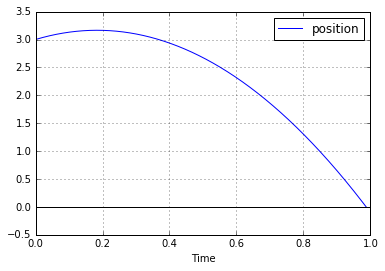

In [542]:
def weight(obj, t):
    return -9.8

obj = Particle(r0=3,v0=1.8)
obj.addforce(weight)
while True:
    obj.increment(dt=0.001)
    if obj.position.values[-1] < 0:
        break
t = obj.position.timeline[-1]
print()
print('Final velocity = {:.2f} m/s'.format(obj.velocity(t)))
print('Max height = {:.2f} meters'.format(max(obj.position.values)))
obj.position.plot(loc='best', labels=['position'])

**Problem 053**

From her bedroom window a girl drops a water-filled balloon to the ground, 6.0 meters below. If the balloon is released from rest, how long is it in the air?

*Answer:* 1.1 seconds

Time in the air = 1.11 seconds


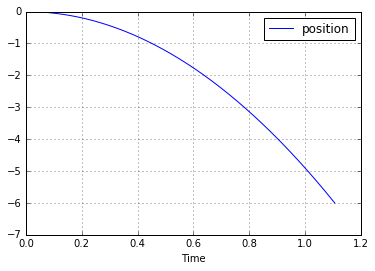

In [12]:
obj = Particle(v0=0)
obj.netforce = lambda t: -9.8
while True:
    obj.increment(dt=0.001)
    if obj.position.values[-1] < -6:
        break

print('Time in the air = {:.2f} seconds'.format(obj.position.timeline[-1]))
obj.position.plot(loc='best', labels=['position'])

**Problem 067** 

A snowmobile moves according to the velocity-time graph shown in the drawing. What is the snowmobile's average acceleration during each of the segments `A`, `B`, `C`?

*Answer:* (a) 1.9 m/s² (b) 0 m/s² (c) 3.3 m/s²

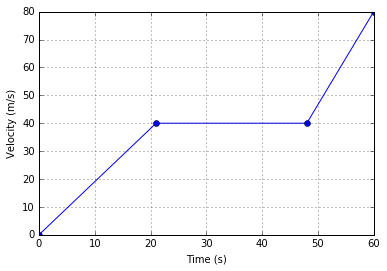

In [18]:
v = TimeSeries([(0,0),(21,40),(48,40),(60,80)])
v.plot(marker='o')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.show()

Acceleration in section 1 is 1.90 m/s²
Acceleration in section 2 is 0.00 m/s²
Acceleration in section 3 is 3.33 m/s²


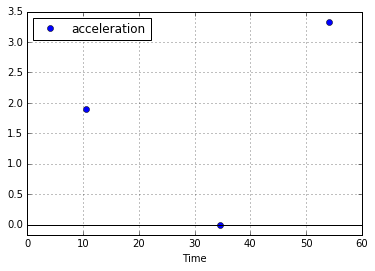

In [16]:
acceleration = v.rate_of_change()
for i, a in enumerate(acceleration.values):
    print('Acceleration in section {} is {:.2f} m/s²'.format(i + 1, a))
    
acceleration.plot(marker='o', lw=0, pad=True, loc='best', labels=['acceleration'])
plt.xlim([v.timeline[0], v.timeline[-1]])
plt.show()

**Problem 068**

A bus makes a trip according to the position-time graph shown in the drawing. What is the average velocity of the bus during each of the segments `A`, `B`, and `C`? Express your answers in km/h.

*Answer:* −20 km/h; 10 km/h; 40 km/h

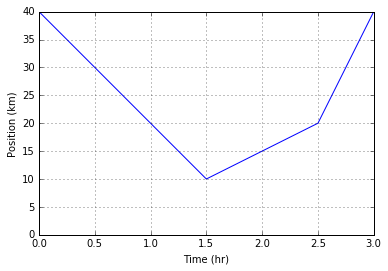

In [24]:
x = TimeSeries([
    (0.0,40),
    (1.5,10),
    (2.5,20),
    (3.0,40),
])
x.plot()
plt.xlabel('Time (hr)')
plt.ylabel('Position (km)')
plt.show()

Velocity in section 1 is -20 m/s
Velocity in section 2 is +10 m/s
Velocity in section 3 is +40 m/s


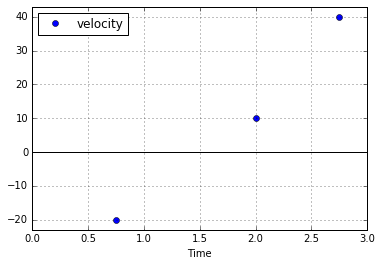

In [568]:
velocity = x.rate_of_change()
for i, v in enumerate(velocity.values):
    print('Velocity in section {} is {:+.0f} km/hr'.format(i + 1, v))
    
velocity.plot(marker='o', lw=0, pad=True, loc='best', labels=['velocity'])
plt.xlim([x.timeline[0], x.timeline[-1]])
plt.show()

**Problem 078**

In 1998, NASA launched *Deep Space I* (DS-1), a spacecraft that successfully flew by the asteroid named 1992 KD (which orbits the sun millions of miles from the earth). The propulsion system of DS-1 worked by ejecting high-speed argon ions out the rear of the engine. The engine slowly increased the velocity of DS-1 by about +9.0 m/s per day. (a) How much time (in days) would it take to increase the velocity of DS-1 by +2700 m/s? (b) What was the acceleration of DS-1 (in m/s²)?

*Answer:* (a) 300 days (b) 1.04E−4 m/s²

Total time = 301 days
Final velocity = 2709 m/s
Average acceleration = 1.042e-04 m/s²
Final displacement = 3.52e+10 meters


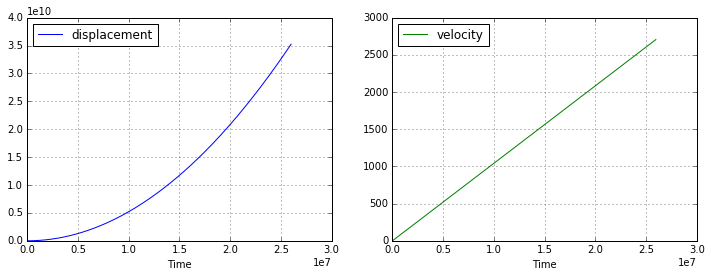

In [577]:
ts = TimeSeries()

t = 0
v = 0
ts.append(t, v)
while True:
    t += 86400
    v += 9.0
    ts.append(t, v)
    if v > 2700:
        break

tf = ts.timeline[-1]
vf = ts.values[-1]

print('Total time = {:,.0f} days'.format(tf / 86400))
print('Final velocity = {:.0f} m/s'.format(vf))

dv = ts.values[-1] - ts.values[0]
dt = ts.timeline[-1] - ts.timeline[0]
print('Average acceleration = {:.3e} m/s²'.format(dv/dt))

obj = Particle()
obj.netforce = lambda t: dv/dt
for i in range(int(tf / 86400)):
    obj.increment(86400)
xf = obj.position.values[-1]    
print('Final displacement = {:.2e} meters'.format(xf))

obj.position.plot('01', loc='upper left', labels=['displacement','velocity'])
plt.show()

**Problem 079**

A cheetah is hunting. Its prey runs for 3.0 seconds at a constant velocity of +9.0 m/s. Starting from rest, what constant acceleration must the cheetah maintain in order to run the same distance as its prey runs in the same time?

*Answer:* 6.0 m/s²

Acceleration = 6.01 m/s²


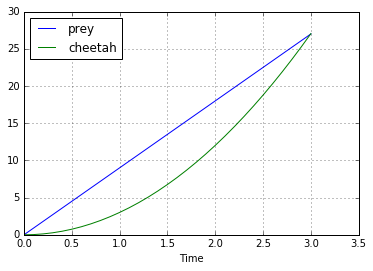

In [8]:
obj1 = Particle(v0=9)
obj1.increment(0.1,30)

a = 0
while True:
    obj2 = Particle(v0=0)
    a += 0.01
    obj2.netforce = lambda t: a
    obj2.increment(0.1,30)
    if obj2.position.values[-1] > obj1.position.values[-1]:
        break
        
print('Acceleration = {:.2f} m/s²'.format(a))
obj1.position.plot(labels=['prey'])
obj2.position.plot(labels=['cheetah'])
plt.legend(loc='upper left')
plt.show()

**Problem 081**

A woman and her dog are out for a morning run to the river, which is located 4.0 kilometers away. The woman runs at 2.5 m/s in a straight line. The dog is unleashed and runs back and forth at 4.5 m/s between his owner and the river, until the woman reaches the river. What is the total distance run by the dog?

*Answer:* 7200 meters

Total distance = 7222.50 meters


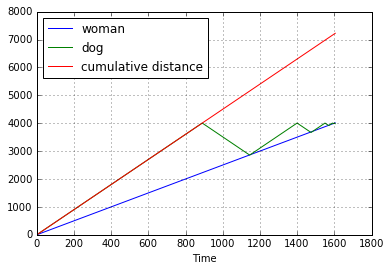

In [9]:
dt = 5
obj1 = Particle(v0=2.5)
obj2 = Particle(v0=4.5)
obj3 = Particle(v0=4.5)
total_distance = 0
while True:
    obj1.increment(dt)
    obj2.increment(dt)
    total_distance += abs(obj2.position.values[-2] - obj2.position.values[-1])
    obj3.increment(5)
    if obj1.position.values[-1] > 4000:
        break
    if obj2.position.values[-1] > 4000:
        obj2.momentum[-1].value = -obj2.momentum[-1].value
    if obj2.position.values[-1] < obj1.position.values[-1] and obj2.position.values[-2] > obj1.position.values[-2]:
        obj2.momentum[-1].value = -obj2.momentum[-1].value
obj1.position.plot(labels=['woman'])
obj2.position.plot(labels=['dog'])
obj3.position.plot(labels=['cumulative distance'], loc='best')
print('Total distance = {:.2f} meters'.format(total_distance))